<a href="https://colab.research.google.com/github/abhilb/mycolab/blob/main/DetectSunglasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/mydatasets

glasses_noGlasses  sunglasses.zip


In [3]:
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_learning_rate = 0.0001

In [5]:
training_dir = Path('drive/MyDrive/mydatasets/glasses_noGlasses/train')
validation_dir  = Path('drive/MyDrive/mydatasets/glasses_noGlasses/valid')

# check if train and test data path exits
print(f"Training data dir exists: {training_dir.exists()}")
print(f"Test data dir exists    : {validation_dir.exists()}")

Training data dir exists: True
Test data dir exists    : True


In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                            label_mode='binary',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True)

Found 3251 files belonging to 2 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 label_mode='binary',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 604 files belonging to 2 classes.


## Data augmentation


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

## Preprocess the image. 
Scale the image to the range -1,1

In [9]:
preprocess_input = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Get the base model
Using the mobilenetv2 as the base model

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_______________________________________________

In [14]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset)

Epoch 1/5
102/102 [==============================] - 392s 4s/step - loss: 0.2325 - accuracy: 0.9326 - val_loss: 0.0820 - val_accuracy: 0.9934
Epoch 2/5
102/102 [==============================] - 113s 1s/step - loss: 0.0696 - accuracy: 0.9929 - val_loss: 0.0400 - val_accuracy: 0.9950
Epoch 3/5
102/102 [==============================] - 112s 1s/step - loss: 0.0406 - accuracy: 0.9954 - val_loss: 0.0273 - val_accuracy: 0.9950
Epoch 4/5
102/102 [==============================] - 121s 1s/step - loss: 0.0286 - accuracy: 0.9966 - val_loss: 0.0215 - val_accuracy: 0.9950
Epoch 5/5
102/102 [==============================] - 118s 1s/step - loss: 0.0228 - accuracy: 0.9972 - val_loss: 0.0183 - val_accuracy: 0.9950


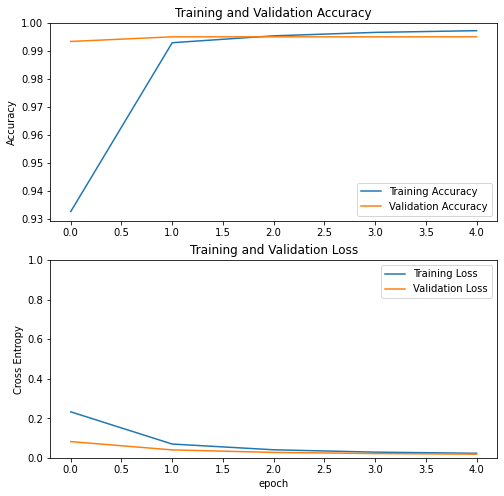

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
test_dataset = validation_dataset.take(1)
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 2s 2s/step - loss: 0.0123 - accuracy: 1.0000
Test accuracy : 1.0


[1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1]
[1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1]


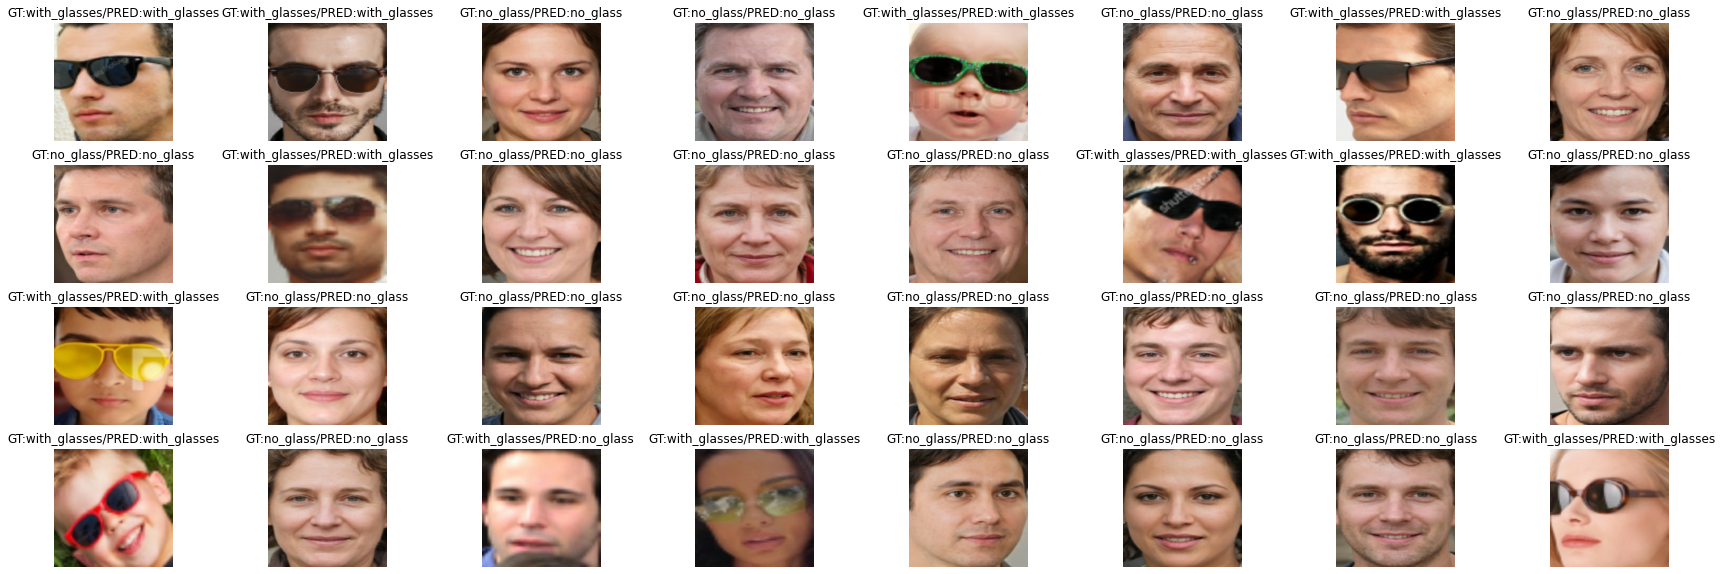

In [17]:
import numpy as np
figure = plt.figure(figsize=(30, 10))

for images, labels in test_dataset:
  num_of_images = images.shape[0]
  preds = np.argmax(model.predict(images), axis=1)
  print(preds)
  print(labels.numpy().flatten().astype(np.int8))
  for idx in range(num_of_images):
    image = images[idx].numpy().astype(np.uint8)
    ax = plt.subplot(4, 8, idx+1)
    ax.axis('off')
    gt = train_dataset.class_names[labels[idx].numpy().astype(np.uint8)[0]]
    pred = train_dataset.class_names[preds[idx]]
    ax.set_title(f'GT:{gt}/PRED:{pred}')
    ax.imshow(image)
plt.show()

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('sunglass_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpqijsjg4n/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
